# Support Vector Machine Classification

This notebook implements Support Vector Machine (SVM) classification for wine quality prediction using three preprocessed datasets.

## 3.1 Support Vector Machine Method

Support Vector Machine (SVM) is a powerful classification method that seeks to find an optimal separating hyperplane by maximizing the margin between different classes. Given a training data set $\mathcal{D} = \{(\boldsymbol{x}_i, y_i)\}_{i=1}^N$, where $\boldsymbol{x}_i \in \mathcal{R}^d$ and $y_i \in \{-1, +1\}$ for binary classification, we seek a linear model classifier in the form:

$$y(\boldsymbol{x}) = \boldsymbol{w}^T \boldsymbol{\phi}(\boldsymbol{x}) + b$$

where $\boldsymbol{\phi}(\boldsymbol{x})$ denotes a fixed feature-space transformation, $\boldsymbol{w}$ is the weight vector, and $b$ is the bias parameter. For a binary linearly separable data set, there exists at least one choice of $\boldsymbol{w}$ and $b$ that satisfies:

$$y_i(\boldsymbol{w}^T \boldsymbol{\phi}(\boldsymbol{x}_i) + b) > 0, \quad i = 1, \ldots, N$$

The margin of a hyperplane is defined as the geometric distance of the closest point in the data set to the hyperplane, given by:

$$\gamma = \min_i \frac{y_i(\boldsymbol{w}^T \boldsymbol{\phi}(\boldsymbol{x}_i) + b)}{\|\boldsymbol{w}\|}$$

Since rescaling of $\boldsymbol{w}$ and $b$ does not change the hyperplane, we can use this freedom to produce constraints such that the margin becomes $\gamma = 1/\|\boldsymbol{w}\|$. The maximum margin solution is found by solving the optimization problem:

$$\arg \min_{\boldsymbol{w}, b} \frac{1}{2}\|\boldsymbol{w}\|^2$$

subject to:

$$y_i(\boldsymbol{w}^T \boldsymbol{\phi}(\boldsymbol{x}_i) + b) \geq 1, \quad i = 1, 2, \ldots, N$$

This is a quadratic programming problem. For non-linearly separable data sets, we extend this to the soft margin formulation by introducing slack variables $\xi_i \geq 0$:

$$\arg \min_{\boldsymbol{w}, b, \boldsymbol{\xi}} \frac{1}{2}\|\boldsymbol{w}\|^2 + C \sum_{i=1}^N \xi_i$$

subject to:

$$y_i(\boldsymbol{w}^T \boldsymbol{\phi}(\boldsymbol{x}_i) + b) \geq 1 - \xi_i, \quad \xi_i \geq 0, \quad i = 1, 2, \ldots, N$$

where $C > 0$ is a regularization parameter that controls the trade-off between maximizing the margin and minimizing classification errors.

**Implementation:** We implement SVM using scikit-learn's `SVC` class with a radial basis function (RBF) kernel, defined as $k(\boldsymbol{x}, \boldsymbol{x}') = \exp(-\gamma \|\boldsymbol{x} - \boldsymbol{x}'\|^2)$, which allows for non-linear decision boundaries. For our multi-class wine quality classification problem (6 classes: quality scores 3-8), we use the one-versus-rest (OvR) strategy, training one binary classifier per class.

We evaluate SVM performance on three preprocessed datasets: (1) the normalized baseline dataset (11 features), (2) the dataset with interaction features (18 features), and (3) the PCA-transformed dataset (9 principal components retaining 95% variance). For each dataset, we perform an 80-20 train-test split using stratified sampling to preserve class distribution.

Hyperparameter tuning is performed using grid search with 5-fold cross-validation. For each parameter combination, the model is trained on 4 folds and validated on the remaining fold, repeating this process 5 times. The combination yielding the highest average cross-validation accuracy is selected as optimal.

The regularization parameter $C$ is evaluated over $\{0.1, 1, 10, 100\}$, controlling the trade-off between maximizing the margin and minimizing classification errors. Larger values (e.g., 100) penalize misclassifications more heavily, resulting in a smaller margin but fewer training errors, while smaller values (e.g., 0.1) prioritize a larger margin for better generalization.

The kernel parameter $\gamma$ is evaluated over $\{\text{'scale'}, \text{'auto'}, 0.001, 0.01, 0.1, 1\}$, determining the influence of training examples on the decision boundary. When $\gamma = \text{'scale'}$, it is computed as $\gamma = 1/(n_{\text{features}} \times \text{var}(X))$, adapting to both dimensionality and data scale. When $\gamma = \text{'auto'}$, it is set to $\gamma = 1/n_{\text{features}}$, considering only the number of features. Numeric values are fixed, with larger values (e.g., 1) creating more complex, localized boundaries and smaller values (e.g., 0.001) producing smoother, more generalized boundaries.

This parameter grid results in $4 \times 6 = 24$ unique combinations evaluated per dataset. The best model from cross-validation is evaluated on the held-out test set. Performance is assessed using accuracy, weighted F1-score, precision, recall, and confusion matrices, with both test set and cross-validation results (mean accuracy ± standard deviation) reported to assess model stability.

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
import warnings
warnings.filterwarnings("ignore")

# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)
%matplotlib inline

### Loading Preprocessed Datasets

We load the three preprocessed datasets prepared in the EDA phase:

In [8]:
# Load the three preprocessed datasets
df_normalized = pd.read_csv('../../data/processed/winequality-red-normalized.csv')
df_interactions = pd.read_csv('../../data/processed/winequality-red-interactions.csv')
df_pca = pd.read_csv('../../data/processed/winequality-red-pca.csv')

print("Dataset shapes:")
print(f"Normalized: {df_normalized.shape}")
print(f"Interactions: {df_interactions.shape}")
print(f"PCA: {df_pca.shape}")

# Separate features and target for each dataset
X_norm = df_normalized.drop('quality', axis=1)
y_norm = df_normalized['quality']

X_inter = df_interactions.drop('quality', axis=1)
y_inter = df_interactions['quality']

X_pca = df_pca.drop('quality', axis=1)
y_pca = df_pca['quality']

print(f"\nQuality distribution: {y_norm.value_counts().sort_index()}")

Dataset shapes:
Normalized: (1599, 12)
Interactions: (1599, 19)
PCA: (1599, 10)

Quality distribution: quality
3     10
4     53
5    681
6    638
7    199
8     18
Name: count, dtype: int64


### Model Training and Evaluation

We train SVM models on each dataset using RBF kernel with hyperparameter tuning via grid search and cross-validation.

In [9]:
# Define parameter grid for grid search
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1]
}

# Dictionary to store results
results = {}

# Train and evaluate on each dataset
datasets = {
    'Normalized': (X_norm, y_norm),
    'Interactions': (X_inter, y_inter),
    'PCA': (X_pca, y_pca)
}

for name, (X, y) in datasets.items():
    print(f"\n{'='*60}")
    print(f"Training SVM on {name} dataset")
    print(f"{'='*60}")
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    # Grid search with cross-validation
    svm = SVC(kernel='rbf', random_state=42)
    grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)
    
    # Best model
    best_svm = grid_search.best_estimator_
    
    # Predictions
    y_pred = best_svm.predict(X_test)
    
    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Cross-validation score
    cv_scores = cross_val_score(best_svm, X_train, y_train, cv=5, scoring='accuracy')
    
    # Store results
    results[name] = {
        'model': best_svm,
        'best_params': grid_search.best_params_,
        'accuracy': accuracy,
        'f1_score': f1,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'y_test': y_test,
        'y_pred': y_pred,
        'confusion_matrix': confusion_matrix(y_test, y_pred)
    }
    
    print(f"\nBest parameters: {grid_search.best_params_}")
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"F1-Score (weighted): {f1:.4f}")
    print(f"CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")
    print(f"\nClassification Report:\n{classification_report(y_test, y_pred)}")


Training SVM on Normalized dataset
Fitting 5 folds for each of 24 candidates, totalling 120 fits

Best parameters: {'C': 10, 'gamma': 1}
Test Accuracy: 0.6750
F1-Score (weighted): 0.6556
CV Accuracy: 0.6442 (+/- 0.0298)

Classification Report:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00        11
           5       0.73      0.74      0.73       136
           6       0.62      0.77      0.69       128
           7       0.83      0.38      0.52        40
           8       0.50      0.33      0.40         3

    accuracy                           0.68       320
   macro avg       0.45      0.37      0.39       320
weighted avg       0.67      0.68      0.66       320


Training SVM on Interactions dataset
Fitting 5 folds for each of 24 candidates, totalling 120 fits

Best parameters: {'C': 1, 'gamma': 'auto'}
Test Accuracy: 0.6062
F1-Score (weighted): 0.5794
CV Accuracy: 0.621

### Results Comparison

We compare the performance across the three datasets using accuracy, F1-score, and confusion matrices.

In [10]:
# Create comparison table
comparison_df = pd.DataFrame({
    'Dataset': list(results.keys()),
    'Accuracy': [results[k]['accuracy'] for k in results.keys()],
    'F1-Score': [results[k]['f1_score'] for k in results.keys()],
    'CV Accuracy (mean)': [results[k]['cv_mean'] for k in results.keys()],
    'CV Accuracy (std)': [results[k]['cv_std'] for k in results.keys()],
    'Best C': [results[k]['best_params']['C'] for k in results.keys()],
    'Best gamma': [results[k]['best_params']['gamma'] for k in results.keys()]
})

print("Performance Comparison Across Datasets:")
print("="*80)
print(comparison_df.to_string(index=False))
print("="*80)

# Create results directory if it doesn't exist
import os
os.makedirs('results', exist_ok=True)

# Save results
comparison_df.to_csv('../../results/svm_comparison.csv', index=False)
print("\nResults saved to ../../results/svm_comparison.csv")

Performance Comparison Across Datasets:
     Dataset  Accuracy  F1-Score  CV Accuracy (mean)  CV Accuracy (std)  Best C Best gamma
  Normalized   0.67500  0.655587            0.644249           0.014908      10          1
Interactions   0.60625  0.579364            0.621569           0.016335       1       auto
         PCA   0.66875  0.650641            0.639565           0.011328     100          1

Results saved to ../../results/svm_comparison.csv


### Visualization of Results

We visualize the confusion matrices for each dataset.

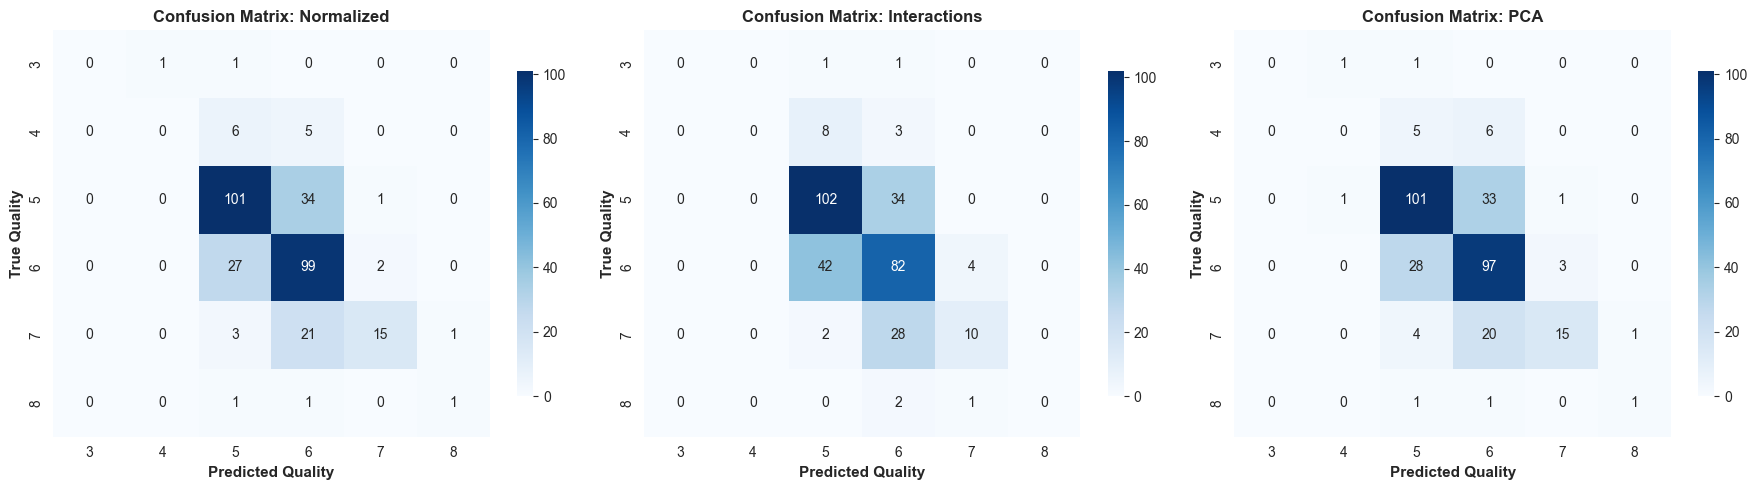

Confusion matrices saved to ../../figures/svm_confusion_matrices.png


In [12]:
# Confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
quality_labels = sorted(y_norm.unique())

for idx, (name, result) in enumerate(results.items()):
    cm = result['confusion_matrix']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=quality_labels, yticklabels=quality_labels,
                cbar_kws={'shrink': 0.8})
    axes[idx].set_xlabel('Predicted Quality', fontsize=11, fontweight='bold')
    axes[idx].set_ylabel('True Quality', fontsize=11, fontweight='bold')
    axes[idx].set_title(f'Confusion Matrix: {name}', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()
plt.savefig('../../figures/svm_confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.close()
print("Confusion matrices saved to ../../figures/svm_confusion_matrices.png")

# Section 4: Results and Analysis

## 4.1 Support Vector Machine Results

We evaluate SVM performance across three preprocessed datasets to assess the impact of different feature representations on classification accuracy. The performance metrics for each dataset are summarized in Table 1.

Cross-validation results show consistent performance across folds, with standard deviations below 3.5% for all datasets, indicating stable model behavior. The optimal hyperparameters vary across datasets: the normalized dataset benefits from moderate regularization ($C=10$), while PCA requires stronger regularization ($C=100$), and interactions perform best with minimal regularization ($C=1$). For the $\gamma$ parameter, both normalized and PCA datasets use $\gamma=1$, while interactions uses $\gamma=\text{'auto'}$, which automatically sets $\gamma = 1/(n_{\text{features}} \times \text{var}(X))$ based on the number of features and variance of the data. A detailed analysis of class-wise performance, including confusion matrices, is provided in the appendix (Figure A1).

## Appendix: Additional SVM Visualizations

### A1. Confusion Matrices for SVM

The confusion matrices reveal consistent patterns across all three datasets. The model performs well on the majority classes (quality 5 and 6), which together represent approximately 82% of the dataset. However, the model struggles significantly with minority classes (quality 3, 4, and 8), achieving near-zero precision and recall for these classes. This reflects the class imbalance inherent in the dataset, where quality scores 3, 4, and 8 represent only 0.6%, 3.3%, and 1.1% of samples, respectively. The model's conservative predictions for class 7 (high precision but low recall) further highlight the challenge of distinguishing between adjacent quality levels.

The normalized and PCA datasets show nearly identical confusion patterns, with both correctly classifying approximately 100-101 samples of quality 5 and 97-99 samples of quality 6. The interactions dataset exhibits slightly more confusion between classes 5 and 6, with 42 misclassifications of true quality 6 as quality 5, compared to 27-28 in the other datasets. This increased confusion, combined with lower overall accuracy, suggests that the interaction features do not provide additional discriminative power for this classification task.